In [1]:
from    __future__                  import  print_function

import argparse
import os
import random
import torch
import torch.nn.parallel
import torch.utils.data
import torch.nn                     as      nn
import torch.backends.cudnn         as      cudnn
import torch.optim                  as      optim
import torchvision.datasets         as      dset
import torchvision.transforms       as      transforms
import torchvision.utils            as      vutils
import numpy                        as      np
import matplotlib.pyplot            as      plt
import matplotlib.animation         as      animation
from    tqdm                        import  tqdm
from    IPython.display             import  HTML

device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

%matplotlib inline
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


##  1.1.Hyper parameters

-  **dataroot** - the path to the root of the dataset folder.
-  **workers** - the number of worker threads for loading the data with the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed.
-  **nc** - number of color channels in the input images. For color images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the generator
-  **ndf** - sets the depth of feature maps propagated through the discriminator
-  **num_epochs** - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
-  **lr** - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number
   of GPUs

In [2]:
dataroot = "Numbers"# Root directory for dataset
workers = 1         # Number of workers for dataloader
batch_size = 128    # Batch size during training
image_size = 64     # All images will be resized to this size using a transformer.
nc = 3              # Number of channels in the training images. For color images this is 3
nz = 100            # Size of z latent vector (i.e. size of generator input)
ngf = 64            # Size of feature maps in generator
ndf = 64            # Size of feature maps in discriminator
num_epochs = 300    # Number of training epochs
lr = 2e-4           # Learning rate for optimizers
beta1 = 0.5         # Beta1 hyperparam for Adam optimizers

# 2.Data
## 2.1. Create the dataset & Dataloader

In [3]:
transformm=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.RandomPerspective(distortion_scale=0.4, p=0.98),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ])

dataset     = dset.ImageFolder(root=dataroot,transform=transformm)
dataloader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

## 2.3. Plot some training images

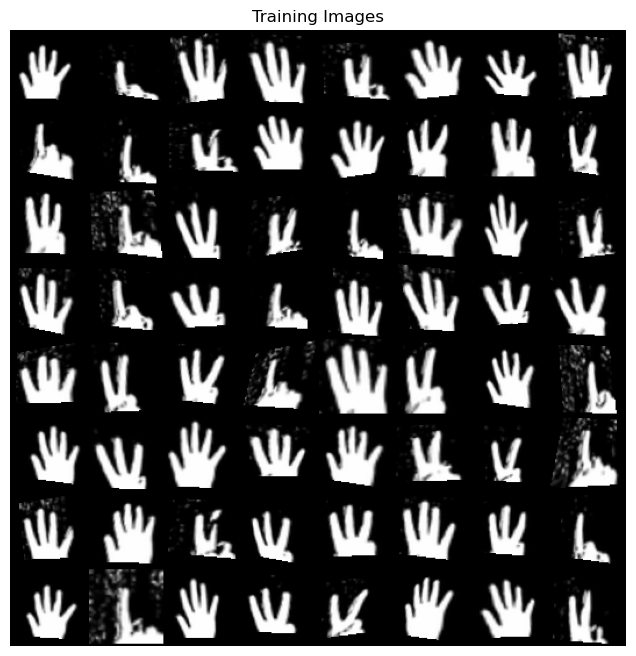

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# 3.implementation 

## 3.1.Generator

The generator, $G$, is designed to map the latent space vector ($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[-1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. 

Notice, how the inputs we set in the input section (*nz*, *ngf*, and *nc*) influence the generator architecture in code. *nz* is the length of the z input vector, *ngf* relates to the size of the feature maps that are propagated through the generator, and *nc* is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## 3.2.Critic

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## 3.3.Weight Initialization


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




## 3.4. Loss Functions and Optimizers




In [8]:
criterion = nn.MSELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD     = optim.RMSprop(netD.parameters(), lr=lr, weight_decay=1e-5)
optimizerG     = optim.RMSprop(netG.parameters(), lr=lr)

# 4.Training


In [9]:
# randomly flip some labels
def noisy_labels(y, p_flip):
	n_select = int(p_flip * y.shape[0])								# determine the number of labels to flip
	flip_ix = np.random.choice([i for i in range(y.shape[0])], size=n_select)	# choose labels to flip
	y[flip_ix] = 1 - y[flip_ix]										# invert the labels in place
	return y

def smooth_positive_labels(y,device):
	return y - 0.3 + (torch.rand(y.shape , device=device) * 0.5)

In [14]:
img_list = []
G_losses = []
D_losses = []
iters = 0
train_D_acc=0
train_G_acc=0

# Create empty results dictionary
results =   {
            "train_D_acc": [],
            "train_G_acc": [],
            }
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader, 0)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))   ## Train with all-real batch
        ########################### 
        netD.zero_grad()
        
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label_ones_noised = noisy_labels(label, 0.05)               # flip labels with 5% probability
        # break
        output = netD(real_cpu).view(-1)                            # Forward pass real batch through D
        
        label = smooth_positive_labels(label,device)

        errD_real = criterion(output, label_ones_noised)            # Calculate loss on all-real batch
        errD_real.backward()                                        # Calculate gradients for D in backward pass
        D_x = output.mean().item()
        
        output[output<0.5]=0
        output[output>0.5]=1
        train_D_acc = ((torch.round(output) == torch.full((b_size,), real_label, dtype=torch.float, device=device)).sum().item()/b_size)
        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)        # Generate batch of latent vectors
        fake = netG(noise)                                          # Generate fake image batch with G
        label.fill_(fake_label)

        label = noisy_labels(label, 0.05)                           # flip labels with 5% probability

        output = netD(fake.detach()).view(-1)                       # Classify all fake batch with D
        errD_fake = criterion(output, label)                        # Calculate D's loss on the all-fake batch
        errD_fake.backward()                                        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake                                # Compute error of D as sum over the fake and the real batches
        optimizerD.step()
        # Update D
        for params in netD.parameters():
                params.data.clamp_(-0.01, +0.01)
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)                                     # fake labels are real for generator cost
        output = netD(fake).view(-1)                                # Since we just updated D, perform another forward pass of all-fake batch through D
        
        label = smooth_positive_labels(label,device)

        label_false_noise = noisy_labels(label, 0.05)
        errG = criterion(output, label_false_noise)                 # Calculate G's loss based on this output
        errG.backward()                                             # Calculate gradients for G
        D_G_z2 = output.mean().item()
        optimizerG.step()                                           # Update G
        output[output<0.5]=0
        output[output>0.5]=1
        train_G_acc = ((torch.round(output) == torch.full((b_size,), real_label, dtype=torch.float, device=device)).sum().item()/b_size)
        # Output training stats
        if iters % num_epochs ==0 : #or i  == len(dataloader)/2:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        results["train_D_acc"].append(train_D_acc)
        results["train_G_acc"].append(train_G_acc)
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % num_epochs == 0) :
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...


 12%|█▎        | 1/8 [00:00<00:02,  2.77it/s]

[0/300][0/8]	Loss_D: 3.1918	Loss_G: 1.0787	D(x): 1.0892	D(G(z)): 0.9035 / -0.0838


 62%|██████▎   | 5/8 [00:01<00:00,  4.42it/s]

[37/300][4/8]	Loss_D: 0.5378	Loss_G: 0.3562	D(x): 0.4982	D(G(z)): 0.4568 / 0.3478


 12%|█▎        | 1/8 [00:00<00:02,  2.99it/s]

[75/300][0/8]	Loss_D: 0.5214	Loss_G: 0.3053	D(x): 0.5217	D(G(z)): 0.4784 / 0.3977


 62%|██████▎   | 5/8 [00:01<00:00,  4.38it/s]

[112/300][4/8]	Loss_D: 0.5213	Loss_G: 0.3682	D(x): 0.5394	D(G(z)): 0.4777 / 0.3591


 12%|█▎        | 1/8 [00:00<00:03,  1.90it/s]

[150/300][0/8]	Loss_D: 0.5221	Loss_G: 0.3993	D(x): 0.6204	D(G(z)): 0.5511 / 0.3210


 62%|██████▎   | 5/8 [00:01<00:00,  4.32it/s]

[187/300][4/8]	Loss_D: 0.4711	Loss_G: 0.3941	D(x): 0.5294	D(G(z)): 0.4086 / 0.3318


 12%|█▎        | 1/8 [00:00<00:02,  2.77it/s]

[225/300][0/8]	Loss_D: 0.5321	Loss_G: 0.4699	D(x): 0.5894	D(G(z)): 0.5096 / 0.2701


 62%|██████▎   | 5/8 [00:01<00:00,  4.16it/s]

[262/300][4/8]	Loss_D: 0.5012	Loss_G: 0.4450	D(x): 0.5740	D(G(z)): 0.4702 / 0.3020


100%|██████████| 8/8 [00:01<00:00,  4.02it/s]


## Results

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




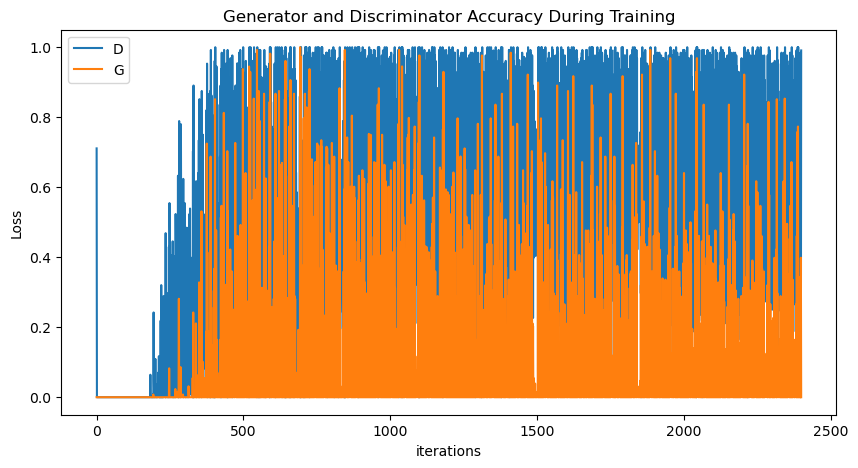

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Accuracy During Training")
plt.plot(results['train_D_acc'],label="D")
plt.plot(results["train_G_acc"],label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



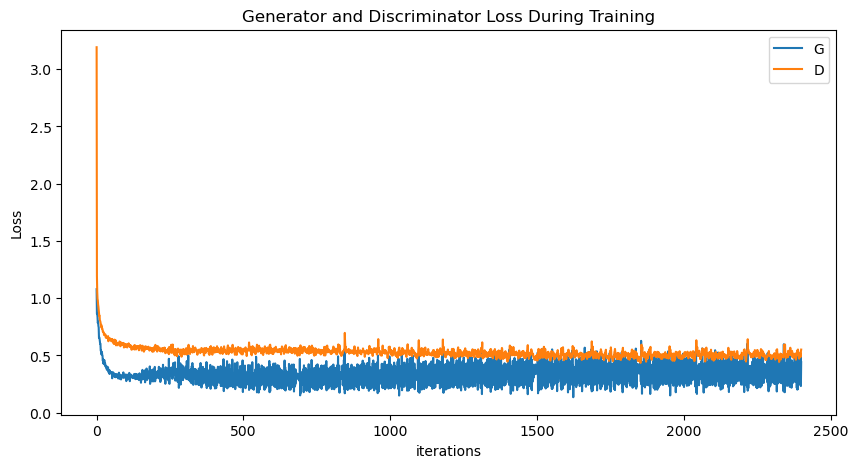

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




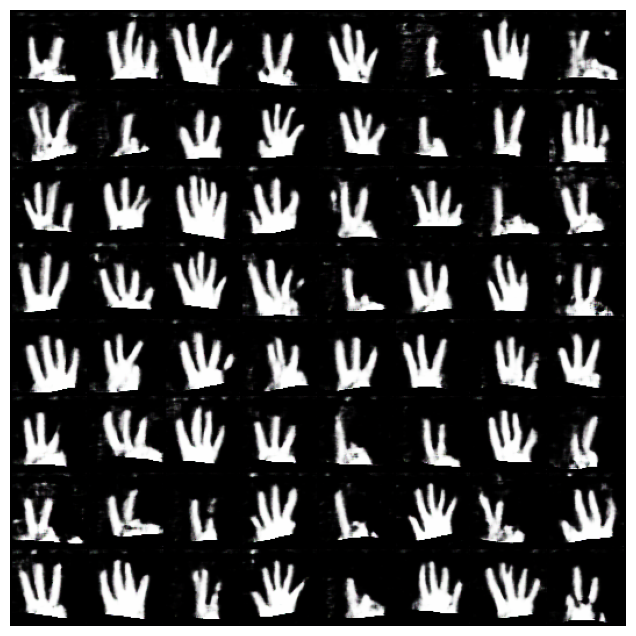

In [17]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




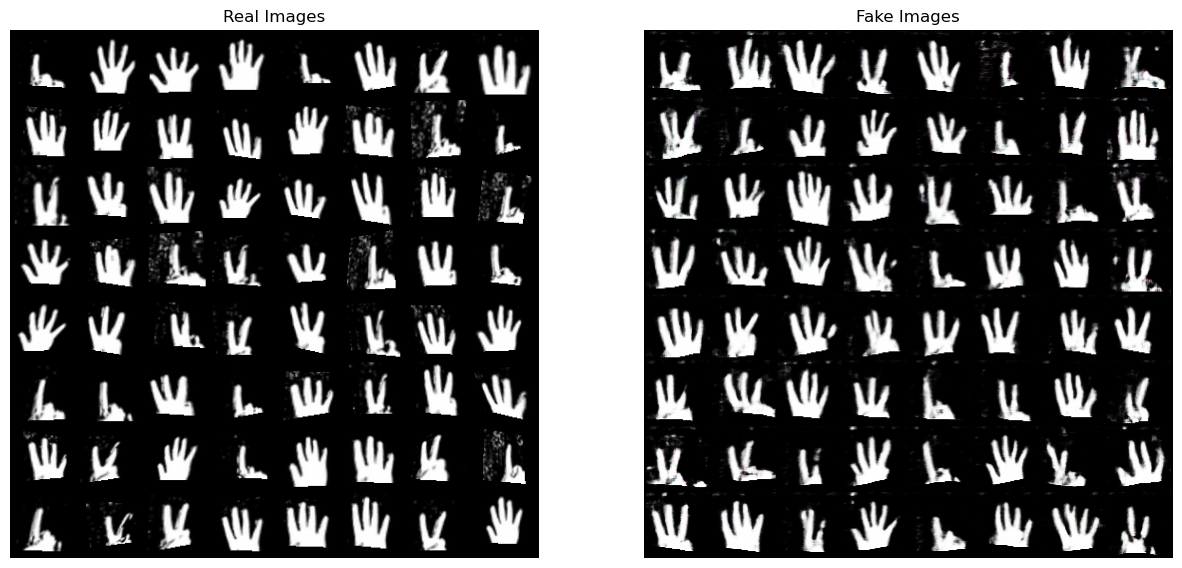

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()